In [1]:
from climada.util.api_client import Client
from climada.util.constants import RIVER_FLOOD_REGIONS_CSV
from climada_petals.entity.impact_funcs.river_flood import ImpfRiverFlood,flood_imp_func_set
import pandas as pd
from climada.engine import Impact
from climada.hazard import Hazard
import numpy as np
from climada.util import yearsets
import os
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp


countries = ['TWN', 'DEU', 'VNM', 'COL', 'USA']
#Define which files are which, would be good to have standardize names
impact_csvs = {}
impact_mats = {}
impact_csvs_crops = {}
impact_mats_crops = {}
data_dir = '/Users/szelie/OneDrive - ETH Zurich/20211208_Multi-Impact_ZelieCarmen'
for country in countries:
    impact_csvs[country] = {}
    impact_mats[country] = {}
    impact_csvs_crops[country] = {}
    impact_mats_crops[country] = {}
    impact_csvs[country]['RF'] = os.path.join(data_dir, "".join(['river_flood_impact_150arcsec_historical_1980_2000_',country,'.csv']))
    impact_mats[country]['RF'] = os.path.join(data_dir, "".join(['river_flood_impact_150arcsec_historical_1980_2000_',country,'.npz']))


    impact_csvs[country]['TC']  = os.path.join(data_dir, "".join(['TC_impact_mat/imp_',country,'.csv']))
    impact_mats[country]['TC']= os.path.join(data_dir, "".join(['TC_impact_mat/imp_mat_',country,'.npz']))
   
    impact_csvs[country]['WF'] = os.path.join(data_dir, "".join(['WF_impact/imp_WF_',country,'.csv']))
    impact_mats[country]['WF'] = os.path.join(data_dir, "".join(['WF_impact/imp_mat_WF_',country,'.npz']))
    
    #crops
    for crop in ['mai','ric','soy','whe']:
        impact_csvs_crops[country][crop] = os.path.join(data_dir, "".join(['CP_impact/imp_',country,'_',crop,'_historical.csv']))
        impact_mats_crops[country][crop] = os.path.join(data_dir, "".join(['CP_impact/imp_mat_',country,'_',crop,'_historical.npz']))

    #landslide
    

In [450]:
#sample events per year
import copy


def downsample_raster(raster_high, res_low, res_high, shape_low):
    """
    Downsamples a raster to a given lower resolutin by averaging over
    a certain area of grid cells.
    Parameters
    ----------
    raster_high : np.array
        Original raster with the high resolution
    res_low : float
        Resolution of the downsampled raster
    bounds : tuple
        (xmin, ymin, xmax, ymax)
    transform : rasterio.Affine
        Affine transformation defining the input raster data.
    shape_low : tuple, optional
        Shape of output with the lower resolutin. Default: Shape matching
        the given resolution and the bounds.
    Returns
    -------
    raster_low : np.array
        Output raster with the low resolution
    """
    if res_high[0] > res_low[0] or res_high[1] > res_low[1]:
        raise ValueError('Low resolution is higher than high resolution: %s < %s.'
                             % (res_low, res_high))

    stencil_x = int(np.floor(res_low[1]/res_high[1]))
    stencil_y = int(np.floor(res_low[0]/res_high[0]))
    
    raster_low = np.zeros(shape_low)

    jump_x = stencil_x
    jump_y = stencil_y

    # to start not in the upper left conrner -> more in the middle
    # coordinates shift is smaller like this
    buffer_y = int(np.floor((raster_high.shape[0]-shape_low[0]*stencil_y)/2))
    buffer_x = int(np.floor((raster_high.shape[1]-shape_low[1]*stencil_x)/2))
    for i in range(0, shape_low[0]):
        for j in range(0, shape_low[1]):
            raster_low[i,j] = np.mean(raster_high[buffer_y+(i*jump_y):buffer_y+(i*jump_y)+stencil_y,
                                                  buffer_x+(j*jump_x):buffer_x+(j*jump_x)+stencil_x])

    return raster_low

def sum_sparse(mat_list):
    mat_agg = np.zeros(mat_list[0].shape,mat_list[0].dtype)
    for a in mat_list:
        mat_agg[a.nonzero()] += a.data
    return mat_agg

def impacts_to_same_resolution(impact_low, impact_high, res_low=None, res_high=None):
    if res_low is None:
        lat_low = np.unique(list(impact_low.coord_exp[n][0] for n in range(len(impact_low.coord_exp))))
        lon_low = np.unique(list(impact_low.coord_exp[n][1] for n in range(len(impact_low.coord_exp))))
        res_low = (np.abs(lat_low[2]-lat_low[1]), np.abs(lon_low[2]-lon_low[1]))

    if res_high is None:
        lat_high = np.unique(list(impact_high.coord_exp[n][0] for n in range(len(impact_high.coord_exp))))
        lon_high = np.unique(list(impact_high.coord_exp[n][1] for n in range(len(impact_high.coord_exp))))
        res_high = (np.abs(lat_high[2]-lat_high[1]), np.abs(lon_high[2]-lon_high[1])) 
        
    shape_low = impact_low.imp_mat.shape

    imp_mat = downsample_raster(impact_high.imp_mat, res_low, res_high, shape_low)
    impact_high.coord_exp = impact_low.coord_exp
    impact_high.imp_mat = imp_mat
    return impact_high
    
def combine_impacts(impact_list, how='sum', exp=None, years=None):
    """

    Parameters
    ----------
    impact_list : sparse.csr_matrix
        matrix num_events x num_exp with impacts.
    how : how to combine the impacts, options are 'sum', 'max'
    exposures : If the exposures are given, the impacts are caped at their value
    
    Returns
    -------
    imp : Impact
        Combined impact
    """
    imp = copy.deepcopy(impact_list[0])
    def test_consitency(list_mat):
        if not np.all(list_mat[:-1] == list_mat[1:]):
            LOGGER.warning('The matrices do not have the same shape and will be scaled to the coarser resolution.')
    if how == 'sum':
        sum_mat = np.sum([impact.imp_mat for impact in impact_list],axis=0)
    if exp is not None:
        exp_mat = np.stack([exp.gdf.value.to_numpy() for n in np.unique(years)])
        def sparse_min(A, B):
            """
            Return the element-wise maximum of sparse matrices `A` and `B`.
            """
            AgtB = (A < B).astype(int)
            M = np.multiply(AgtB, A - B) + B
            return sp.sparse.csr_matrix(M)
        sum_mat = sparse_min(sum_mat, exp_mat)
    imp = imp.set_imp_mat(sum_mat)
    return imp

def sample_events(impact, lam=1, years = np.array(range(1980,2000))):
    #create sampling vector
    events_per_year = yearsets.sample_from_poisson(len(years), lam)
    sampling_vect = yearsets.sample_events(events_per_year, impact.frequency)
    impact_sample = yearsets.impact_from_sample(impact, years, sampling_vect)
    return impact_sample 


def open_impacts(country, csv, impact_mat):
    try:
        impact = Impact.from_csv(csv)
        impact.imp_mat = impact.read_sparse_csr(impact_mat)
        return impact
    except:
        print("".join([" No data for ", str(country)]))
        return(None)

def make_yearset(impact, country=None, n_samples=1, years=np.array(range(1,400))):
    lam = np.sum(impact.frequency)
    lam = np.round(lam, 10)
    yearset_list = [sample_events(impact, lam=lam, years=years) for n in range(n_samples)]
    if yearset_list[0].imp_mat.shape[0]>len(years):
        client =Client()
        exposures = client.get_litpop_default(country)
        yearset_list = [yearsets.aggregate_impact_to_year(yearset, exp=exposures) for yearset in yearset_list]
        
    return(yearset_list)

In [307]:
impacts = {country:{hazard: open_impacts(country, impact_csvs[country][hazard], 
                                                  impact_mats[country][hazard]) for hazard in impact_csvs[country]} for country in impact_csvs}
impacts_yearsets = {country:{hazard: make_yearset(impacts[country][hazard], country, n_samples=100, years=np.array(range(1,20))) for hazard in impacts[country] if impacts[country][hazard]!=None} for country in impacts}

 No data for VNM
 No data for COL


/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_2354/3699137331.py:118: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types.Specify dtype option on import or set low_memory=False.
  impact = Impact.from_csv(csv)


 No data for USA


In [431]:
impacts['TWN']['TC'].imp_mat.shape[1]

1852

In [308]:
event_select_hist = ["gen" not in event for event in impacts['TWN']['TC'].event_name]

In [390]:
from datetime import datetime as dt
d = dt.strptime('2000-01-01', '%Y-%m-%d').date()
d = d.toordinal()
event_select_date = [date<d for date in impacts['TWN']['TC'].date]
event_select = np.logical_and(event_select_date,event_select_hist)
ids_select = impacts['TWN']['TC'].event_id[event_select]
impact_hist = impacts['TWN']['TC'].select(event_ids=ids_select)
impact_hist = impact_hist.set_imp_mat(impact_hist.imp_mat)

In [349]:
from datetime import datetime as dt
d = dt.strptime('2000-01-01', '%Y-%m-%d').date()
d = d.toordinal()
event_select_date = [date<d for date in impacts['TWN']['TC'].date]
event_select = event_select_hist
ids_select = impacts['TWN']['TC'].event_id[event_select]
impact_hist_1980_2020 = impacts['TWN']['TC'].select(event_ids=ids_select)
impact_hist_1980_2020 = impact_hist.set_imp_mat(impact_hist.imp_mat)

In [350]:
impact_hist_year_1980_2020 = yearsets.aggregate_impact_to_year(impact_hist_1980_2020, exposures_twn)
impact_tc_hist_year_1980_2020 = impact_hist_year.set_imp_mat(impact_hist_year_1980_2020.imp_mat)

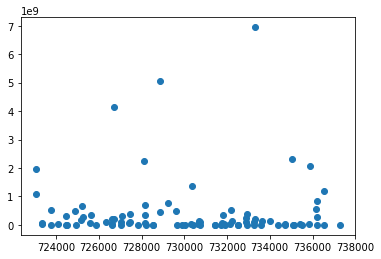

In [351]:
plt.scatter(impact_hist_1980_2020.date[impact_hist_1980_2020.at_event>0], impact_hist_1980_2020.at_event[impact_hist_1980_2020.at_event>0])

In [352]:
timeseries = [date for date in impact_hist_1980_2020.date if dt.fromordinal(int(date)).month>5]
timeseries_impact = [np.sum(impact_hist_1980_2020.at_event[impact_hist_1980_2020.date==t]) for t in timeseries]

In [353]:
timeseries_impact

[0.0,
 4149617350.4760323,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 457505.68675437785,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

Text(0.5, 0, 'Lag [Years]')

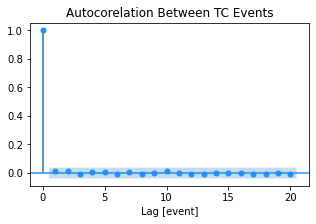

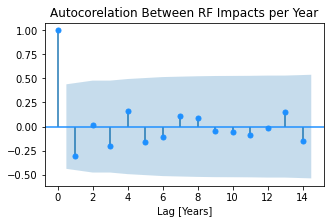

In [354]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
# Use the Autocorrelation function
# from the statsmodel library passing
# our DataFrame object in as the data
# Note: Limiting Lags to 50

fig,ax = plt.subplots(figsize=(5,3))
plot_acf(np.array(timeseries_impact),lags=20, title='Autocorelation Between TC Events', ax=ax, color="dodgerblue")
plt.xlabel('Lag [event]')
# Show the AR as a plot
fig,ax = plt.subplots(figsize=(5,3))

plot_acf(np.array(impact_rf_hist_year.at_event), title='Autocorelation Between RF Impacts per Year', ax=ax, color="dodgerblue")
plt.xlabel('Lag [Years]')



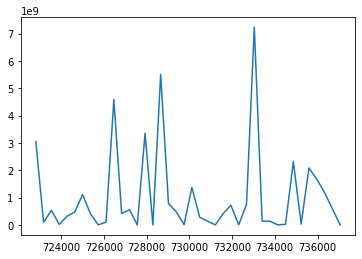

In [355]:
plt.plot(impact_tc_hist_year_1980_2020.date[impact_tc_hist_year_1980_2020.at_event>0], impact_tc_hist_year_1980_2020.at_event[impact_tc_hist_year_1980_2020.at_event>0])

In [356]:
impact_tc_hist_year_1980_2020.at_event[impact_tc_hist_year_1980_2020.at_event>0]

array([3.05669944e+09, 9.29075404e+07, 5.38561268e+08, 1.87345521e+07,
       3.16806849e+08, 4.77920666e+08, 1.11338967e+09, 4.08771824e+08,
       2.15052004e+06, 1.00498783e+08, 4.58397576e+09, 4.13753289e+08,
       5.56619622e+08, 7.24842560e+02, 3.34873466e+09, 3.24196543e+05,
       5.50573839e+09, 7.82187892e+08, 4.79098890e+08, 1.20942615e+07,
       1.37399718e+09, 2.79717322e+08, 2.19892828e+05, 4.09832334e+08,
       7.21164596e+08, 4.42482975e+06, 7.50020277e+08, 7.23377208e+09,
       1.40007923e+08, 1.37524185e+08, 2.41640526e+06, 1.99311000e+07,
       2.31709662e+09, 2.81914124e+07, 2.08223237e+09, 1.67731478e+09,
       1.18192967e+09, 8.72392593e+05])

In [357]:
impact_hist = impacts['TWN']['TC'].select(event_ids=ids_select)

In [358]:
impact_hist = impact_hist.set_imp_mat(impact_hist.imp_mat)

In [359]:
from climada.util.api_client import Client
from scipy.sparse import coo_matrix, csr_matrix, vstack, hstack
client=Client()
exposures_twn = client.get_litpop_default('TWN')

In [471]:
impact_hist_year = yearsets.aggregate_impact_to_year(impact_hist, exposures_twn)
impact_tc_hist_year = impact_hist_year.set_imp_mat(impact_hist_year.imp_mat)

In [393]:
impact_at_event_rf_hist = [[impacts['TWN']['RF'].at_event[n] for n in range(len(impacts['TWN']['RF'].at_event)) if impacts['TWN']['RF'].date[n] == date] for date in np.unique(impacts['TWN']['RF'].date)]

In [363]:
scipy.stats.normaltest(impact_at_event_rf_hist[2])


NormaltestResult(statistic=12.745052995102764, pvalue=0.0017078389193941473)

In [364]:
matrices_years = [csr_matrix(np.median(vstack([impacts['TWN']['RF'].imp_mat[n] for n in range(len(impacts['TWN']['RF'].at_event)) if impacts['TWN']['RF'].date[n] == date]).todense(),axis=0)) for date in np.unique(impacts['TWN']['RF'].date)]

In [472]:
impact_rf_hist_year = Impact()
impact_rf_hist_year.frequency = np.ones(20)
impact_rf_hist_year = impact_rf_hist_year.set_imp_mat(vstack(matrices_years))

Text(0, 0.5, 'Frequency')

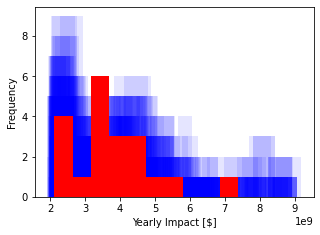

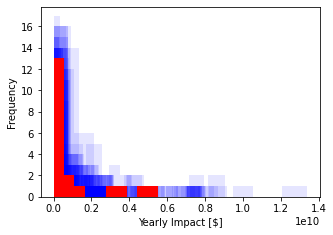

In [409]:
fig, ax = plt.subplots(figsize=(5,3.5))
[ax.hist(yearset.at_event, color='blue', alpha=0.1) for yearset in impacts_yearsets['TWN']['RF']]
ax.hist(impact_rf_hist_year.at_event, color='red', alpha=1)
ax.set_xlabel('Yearly Impact [$]')
ax.set_ylabel('Frequency')


fig, ax = plt.subplots(figsize=(5,3.5))
[ax.hist(yearset.at_event, color='blue', alpha=0.1) for yearset in impacts_yearsets['TWN']['TC']]
ax.hist(impact_tc_hist_year.at_event, color='red')
ax.set_xlabel('Yearly Impact [$]')
ax.set_ylabel('Frequency')




<AxesSubplot:ylabel='Count'>

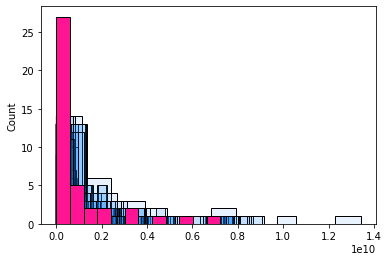

In [329]:
import seaborn as sns
fig, ax = plt.subplots()
[sns.histplot(yearset.at_event,color="dodgerblue", alpha=0.1,ax=ax) for yearset in impacts_yearsets['USA']['TC']]

sns.histplot(impact_tc_hist_year.at_event, ax=ax, color="deeppink", alpha=1)

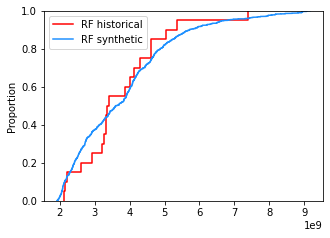

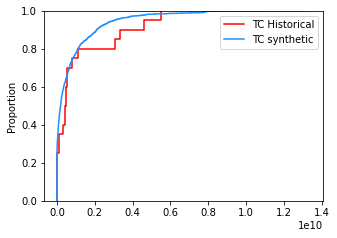

In [411]:
fig, ax = plt.subplots(figsize=(5,3.5))

all_events_rf = np.concatenate([yearset.at_event for yearset in impacts_yearsets['TWN']['RF']])
sns.ecdfplot(x = impact_rf_hist_year.at_event,ax=ax, label='RF historical',color="red")
sns.ecdfplot(x = all_events_rf, ax=ax, label='RF synthetic', color="dodgerblue")
ax.legend()



fig, ax = plt.subplots(figsize=(5,3.5))

all_events_tc = np.concatenate([yearset.at_event for yearset in impacts_yearsets['TWN']['TC']])
sns.ecdfplot(x = impact_tc_hist_year.at_event,ax=ax, label='TC Historical', color="red")
sns.ecdfplot(x = all_events_tc, ax=ax, label='TC synthetic', color="dodgerblue")
ax.legend()




In [368]:
impact_rf_hist_year.date

array([], dtype=int64)

In [404]:
import scipy
kstest_tc = scipy.stats.kstest(impact_tc_hist_year.at_event, all_events_tc)
kstest_rf = scipy.stats.kstest(impact_tc_hist_year.at_event, all_events_rf)

In [405]:
kstest_tc

KstestResult(statistic=0.2294736842105263, pvalue=0.21349560957623503)

In [406]:
kstest

KstestResult(statistic=0.21052631578947367, pvalue=0.301270901498071)

In [389]:
len(impact_tc_hist_year.at_event)

41

In [448]:
combined_yearsets[0].aai_agg

413848802.8486641

In [447]:
impacts_yearsets['TWN']['TC'][0].aai_agg


413848802.8486641

In [425]:
impact_tc_hist_year.aai_agg

1090448439.886373

In [426]:
combined_historical_impact.aai_agg

1090448439.886373

In [423]:
impacts_yearsets['TWN']['RF'][0].aai_agg

3552754065.7454424

In [470]:
combined_sorted = impact_tc_hist_year.at_event + impact_rf_hist_year.at_event
combined_historical_impact = combine_impacts([impact_tc_hist_year,impact_rf_hist_year], exp=exposures_twn, years=np.arange(20))
combined_yearsets = [combine_impacts([impacts_yearsets['TWN']['TC'][n],impacts_yearsets['TWN']['RF'][n]], exp=exposures_twn) for n in range(len(impacts_yearsets['TWN']['RF']))]



In [466]:
combined_sorted

array([2.12019351e+09, 2.14219674e+09, 2.22517403e+09, 2.62085861e+09,
       2.93329678e+09, 3.29918205e+09, 3.38324303e+09, 3.63376936e+09,
       3.74710640e+09, 3.78210168e+09, 3.89024226e+09, 4.35454041e+09,
       4.55632837e+09, 4.67610142e+09, 5.09490894e+09, 5.72137735e+09,
       7.67505312e+09, 8.39017279e+09, 9.94914025e+09, 1.28893137e+10])

In [456]:
np.sort(combined_historical_impact.at_event)

array([2.13228704e+09, 2.22334771e+09, 3.01506101e+09, 3.16538397e+09,
       3.31696324e+09, 3.69151607e+09, 3.72912844e+09, 3.74483578e+09,
       3.75208787e+09, 4.01991762e+09, 4.48173806e+09, 4.63708823e+09,
       4.79064171e+09, 5.19857198e+09, 5.39017557e+09, 5.45807203e+09,
       7.46821646e+09, 7.86267424e+09, 9.38117991e+09, 9.62541389e+09])

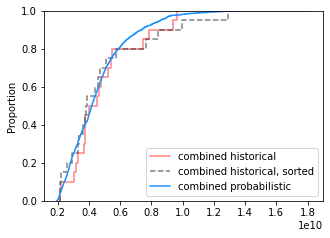

In [488]:
fig, ax = plt.subplots(figsize=(5,3.5))

all_events = np.concatenate([yearset.at_event for yearset in combined_yearsets])
sns.ecdfplot(x = combined_historical_impact.at_event,ax=ax, label ='combined historical', color="red", alpha=0.5)
sns.ecdfplot(x = combined_sorted , ax=ax, label ='combined historical, sorted', color="black", alpha=0.5, linestyle='--')


sns.ecdfplot(x = all_events, ax=ax, label ='combined probabilistic', color="dodgerblue")
ax.legend()



In [414]:
all_events_tc

array([1.00916806e+09, 1.88809577e+09, 8.86213658e+06, ...,
       1.26794779e+09, 7.66911688e+07, 2.69876472e+09])

Text(0, 0.5, 'Frequency')

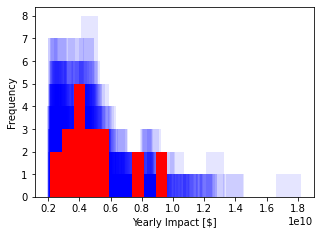

In [453]:
fig, ax = plt.subplots(figsize=(5,3.5))
[ax.hist(yearset.at_event, color='blue', alpha=0.1) for yearset in combined_yearsets]
ax.hist(combined_historical_impact.at_event, color='red')
ax.set_xlabel('Yearly Impact [$]')
ax.set_ylabel('Frequency')



In [486]:
scipy.stats.ks_2samp(combined_historical_impact.at_event, all_events_rf)

KstestResult(statistic=0.27631578947368424, pvalue=0.07965857343087035)

In [287]:
exp_mat = exposures_usa.gdf.value.to_numpy()

In [288]:
exp_mat[exp_mat==0]=1
imp_mat_tc_hist_years = impact_tc_hist_year.imp_mat/exp_mat
imp_mat_rf_hist_years = impact_rf_hist_year.imp_mat/exp_mat


In [289]:
imp_mat_tc_hist_years = np.array(imp_mat_tc_hist_years.flatten())
imp_mat_rf_hist_years = np.array(imp_mat_rf_hist_years.flatten())

In [290]:
both_hazard = np.logical_and((imp_mat_tc_hist_years>0), (imp_mat_rf_hist_years>0))

In [291]:
imp_mat_tc_hist_years.shape

(1, 12861980)

In [292]:
imp_mat_tc_hist_years_both = imp_mat_tc_hist_years[both_hazard]
imp_mat_rf_hist_years_both = imp_mat_rf_hist_years[both_hazard]



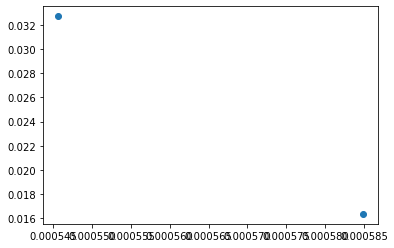

In [293]:
plt.scatter(np.array(imp_mat_tc_hist_years_both.flatten()), np.array(imp_mat_rf_hist_years_both.flatten()))

In [ ]:
plt.scatter(impact_rf_hist_year.eai_exp, impact_tc_hist_year.eai_exp)

In [ ]:
both_hazard = np.logical_and(impact_rf_hist_year.eai_exp>0, impact_tc_hist_year.eai_exp>0)

In [ ]:
np.sum(both_hazard)

In [ ]:
impact_rf_hist_year.imp_mat = impact_rf_hist_year.imp_mat/exp_mat
impact_tc_hist_year.imp_mat = impact_tc_hist_year.imp_mat/exp_mat


for n in range(22):
    fig,ax = plt.subplots()
    ax.scatter(range(20),np.array((impact_rf_hist_year.imp_mat[:,both_hazard][:,n]).flatten())[0])
    ax.scatter(range(20),np.array((impact_tc_hist_year.imp_mat[:,both_hazard][:,n]).flatten())[0])

In [ ]:
np.correlate(np.array(impact_tc_hist_year.imp_mat.flatten())[0],np.array(impact_tc_hist_year.imp_mat.flatten())[0])

In [ ]:
np.array(impact_tc_hist_year.imp_mat[:,both_hazard].flatten())[0]

In [ ]:
np.correlate(np.array(impact_tc_hist_year.imp_mat.flatten())[0],np.array(impact_rf_hist_year.imp_mat.flatten())[0])